# Cell

A `@cell` is a decorator for functions that return a Component. Make sure you add the `@cell` decorator to each function that returns a Component so you avoid having multiple components with the same name.

Why do you need to add the `@cell` decorator?

- In GDS each component must have a unique name. Ideally the name is also consistent from run to run, in case you want to merge GDS files that were created at different times or computers.
- Two components stored in the GDS file cannot have the same name. They need to be references (instances) of the same component. See `References tutorial`. That way we only have to store the component in memory once and all the references are just pointers to that component.

What does the `@cell` decorator does?

1. Gives the component a unique name depending on the parameters that you pass to it.
2. Creates a cache of components where we use the name as the key. The first time the function runs, the cache stores the component, so the second time, you get the component directly from the cache, so you don't create the same component twice.


What is a decorator?

A decorator is a function that runs over a function, so when you do.

```python
@gf.cell
def mzi_with_bend():
    c = gf.Component()
    mzi = c << gf.components.mzi()
    bend = c << gf.components.bend_euler()
    return c
```
it's equivalent to

```python
def mzi_with_bend():
    c = gf.Component()
    mzi = c << gf.components.mzi()
    bend = c << gf.components.bend_euler(radius=radius)
    return c


mzi_with_bend_decorated = gf.cell(mzi_with_bend)
```

Lets see how it works.

this cell 'Unnamed_0' does NOT get automatic name


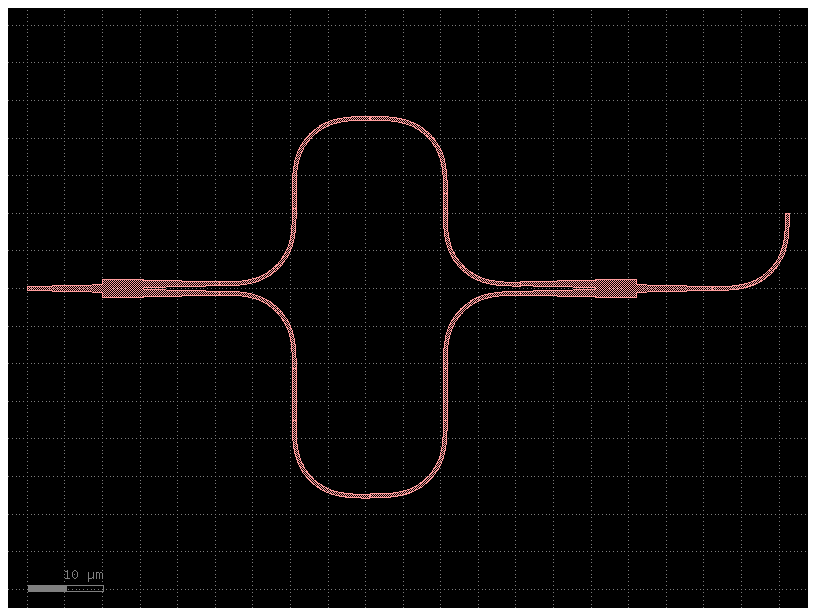

In [1]:
import gdsfactory as gf


def mzi_with_bend(radius: float = 10.0) -> gf.Component:
    c = gf.Component()
    mzi = c << gf.components.mzi()
    bend = c << gf.components.bend_euler(radius=radius)
    bend.connect("o1", mzi.ports["o2"])
    return c


c = mzi_with_bend()
print(f"this cell {c.name!r} does NOT get automatic name")
c.plot()

this cell 'mzi_with_bend_R10' gets automatic name thanks to the `cell` decorator


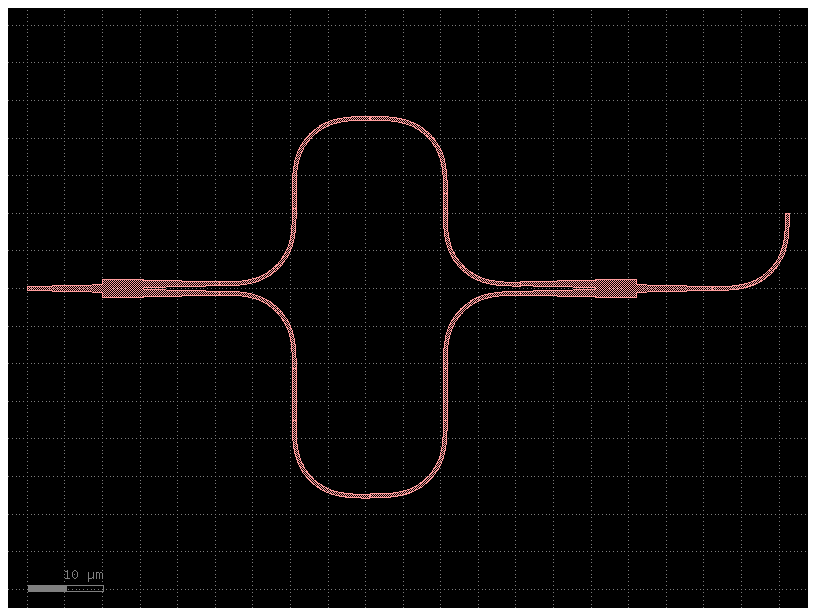

In [2]:
mzi_with_bend_decorated = gf.cell(mzi_with_bend)
c = mzi_with_bend_decorated(radius=10)
print(f"this cell {c.name!r} gets automatic name thanks to the `cell` decorator")
c.plot()

this cell 'mzi_with_bend_R10' gets automatic name thanks to the `cell` decorator


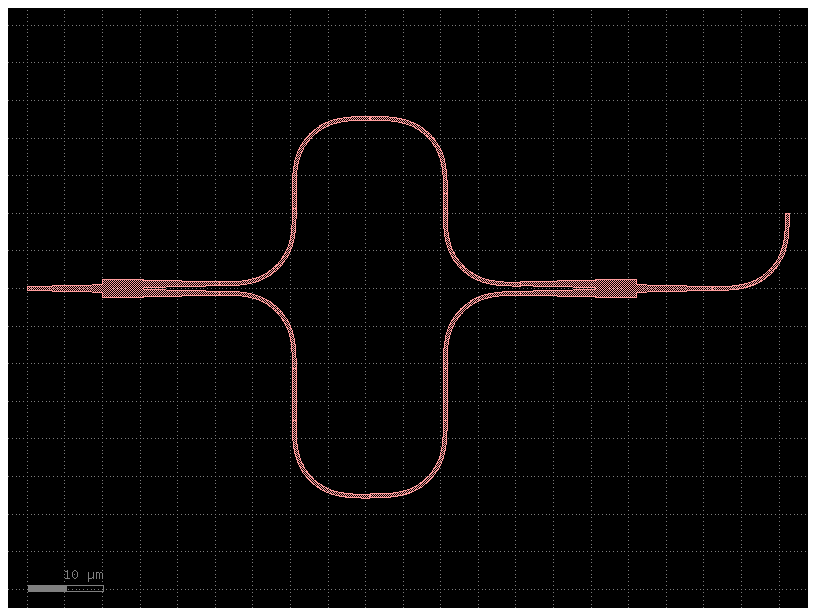

In [3]:
@gf.cell
def mzi_with_bend(radius: float = 10.0) -> gf.Component:
    c = gf.Component()
    mzi = c << gf.components.mzi()
    bend = c << gf.components.bend_euler(radius=radius)
    bend.connect("o1", mzi.ports["o2"])
    return c


print(f"this cell {c.name!r} gets automatic name thanks to the `cell` decorator")
c.plot()

In [4]:
# See how the cells get the name from the parameters that you pass them

c = mzi_with_bend()
print(c)

print("second time you get this cell from the cache")
c = mzi_with_bend()
print(c)

print("If you call the cell with different parameters, the cell gets a different name")
c = mzi_with_bend(radius=20)
print(c)

Component(name=mzi_with_bend_R10, ports=[], instances=['mzi_DL10_LY2_LX0p1_Bben_4daac747_0_0', 'bend_euler_R10_A90_P0p5_2f1f5c6d_81100_0'], locked=True, kcl=DEFAULT)
second time you get this cell from the cache
Component(name=mzi_with_bend_R10, ports=[], instances=['mzi_DL10_LY2_LX0p1_Bben_4daac747_0_0', 'bend_euler_R10_A90_P0p5_2f1f5c6d_81100_0'], locked=True, kcl=DEFAULT)
If you call the cell with different parameters, the cell gets a different name
Component(name=mzi_with_bend_R20, ports=[], instances=['mzi_DL10_LY2_LX0p1_Bben_4daac747_0_0', 'bend_euler_R20_A90_P0p5_b207852f_81100_0'], locked=True, kcl=DEFAULT)


Sometimes when you are changing the inside code of the function, you need to remove the component from the cache to make sure the code runs again.

This is useful when using jupyter notebooks or the file watcher.

In [5]:
@gf.cell
def wg(length=10, width=1, layer=(1, 0)):
    print("BUILDING waveguide")
    c = gf.Component()
    c.info["area"] = width * length
    c.add_polygon([(0, 0), (length, 0), (length, width), (0, width)], layer=layer)
    c.add_port(
        name="o1", center=[0, width / 2], width=width, orientation=180, layer=layer
    )
    c.add_port(
        name="o2", center=[length, width / 2], width=width, orientation=0, layer=layer
    )
    return c

In [6]:
c = wg()
gf.clear_cache()
c = wg()
gf.clear_cache()
c = wg()
gf.clear_cache()

BUILDING waveguide
BUILDING waveguide
BUILDING waveguide


Another option is to just delete the cell after creating it.

In [7]:
c = wg(length=11)
c.delete()
c = wg(length=11)

BUILDING waveguide
BUILDING waveguide


## Settings and Info

Together with the GDS file that you send to the foundry you can also store the settings for each Component.

- `Component.settings` are the input settings for each Cell to Generate a Component. For example, `wg.settings.length` will return you the input `length` setting that you used to create that waveguide.
- `Component.info` are the derived properties that will be computed inside the Cell function. For example `wg.info.area` will return the computed area of that waveguide.


In [8]:
c.info

Info(area=11)

In [9]:
c.info.area

11

In [10]:
c.settings

KCellSettings(length=11, width=1, layer=(1, 0))

In [11]:
c.settings.length

11

Components also have pretty print for ports `c.pprint_ports()`

In [12]:
c.pprint_ports()

┏━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ name ┃ width ┃ orientation ┃ layer    ┃ center      ┃ port_type ┃
┡━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ o1   │ 1.0   │ 180.0       │ WG (1/0) │ (0.0, 0.5)  │ optical   │
│ o2   │ 1.0   │ 0.0         │ WG (1/0) │ (11.0, 0.5) │ optical   │
└──────┴───────┴─────────────┴──────────┴─────────────┴───────────┘

In [13]:
# you always add any relevant information `info` to the cell
c.info["polarization"] = "te"
c.info["wavelength"] = 1.55
c.info

Info(area=11, polarization='te', wavelength=1.55)

## Cache

To avoid that 2 exact cells are not references of the same cell the `cell` decorator has a cache where if a component has already been built it will return the component from the cache

In [14]:
@gf.cell
def straight(length=10, width=1):
    c = gf.Component()
    c.add_polygon([(0, 0), (length, 0), (length, width), (0, width)], layer=(1, 0))
    print(f"BUILDING {length}um long straight waveguide")
    return c

If you run the cell below multiple times it will print a message because we are deleting the CACHE every single time and every time the cell will have a different Unique Identifier (UID).

In [15]:
wg1 = straight()
id(wg1)

BUILDING 10um long straight waveguide


131094935971712

If you run the cell below multiple times it will NOT print a message because we are hitting CACHE every single time and every time the cell will have the SAME Unique Identifier (UID) because it's the same cell.

In [16]:
wg2 = straight(length=10)
# cell returns the same straight as before without having to run the function
print(id(wg2))  # notice that they have the same uuid (unique identifier)

131094935971712


In [17]:
wg3 = straight(length=12)
wg4 = straight(length=13)

BUILDING 12um long straight waveguide
BUILDING 13um long straight waveguide


## Create cells without `cell` decorator

The cell decorator names cells deterministically and uniquely based on the name of the functions and its parameters.

It also uses a caching mechanisms that improves performance and guards against duplicated names.

The most common mistake new gdsfactory users make is to create cells without the `cell` decorator.

### Avoid naming cells manually: Use cell decorator

Naming cells manually is susceptible to name collisions

in GDS you can't have two cells with the same name.

For example: this code will raise a `duplicated cell name ValueError`

```python
import gdsfactory as gf

c1 = gf.Component("wg")
c1 << gf.components.straight(length=5)


c2 = gf.Component("wg")
c2 << gf.components.straight(length=50)


c3 = gf.Component("waveguides")
wg1 = c3 << c1
wg2 = c3 << c2
wg2.dmovey(10)
c3
```

**Solution**: Use the `gf.cell` decorator for automatic naming your components.

In [18]:
import gdsfactory as gf


@gf.cell
def wg(length: float = 3):
    return gf.components.straight(length=length)


gf.clear_cache()
print(wg(length=5).name)
print(wg(length=10).name)

wg_L5
wg_L10


### Avoid Unnamed cells. Use `cell` decorator

In the case of not wrapping the function with `cell` you will get unique names thanks to the unique identifier `uuid`.

This name will be different and non-deterministic for different invocations of the script.

However it will be hard for you to know where that cell came from.

In [19]:
c1 = gf.Component()
c2 = gf.Component()

print(c1.name)
print(c2.name)

Unnamed_26
Unnamed_27


Notice how gdsfactory raises a Warning when you save this `Unnamed` Components

In [20]:
c1.write_gds()

PosixPath('/tmp/gdsfactory/Unnamed_26.gds')

### Avoid Intermediate Unnamed cells. Use `cell` decorator

While creating a cell, you should not create intermediate cells, because they won't be Cached and you can end up with duplicated cell names or name conflicts, where one of the cells that has the same name as the other will be replaced.


```python

@gf.cell
def die_bad():
    """c1 is an intermediate Unnamed cell"""
    c1 = gf.Component() # this is an intermediate cell, it is not named as it is not returned by the function
    _ = c1 << gf.components.straight(length=10)
    return gf.components.die_bbox(c1, street_width=10)


c = die_bad()
c.show()
c.plot()

```

**Solution** Don't use intermediate cells


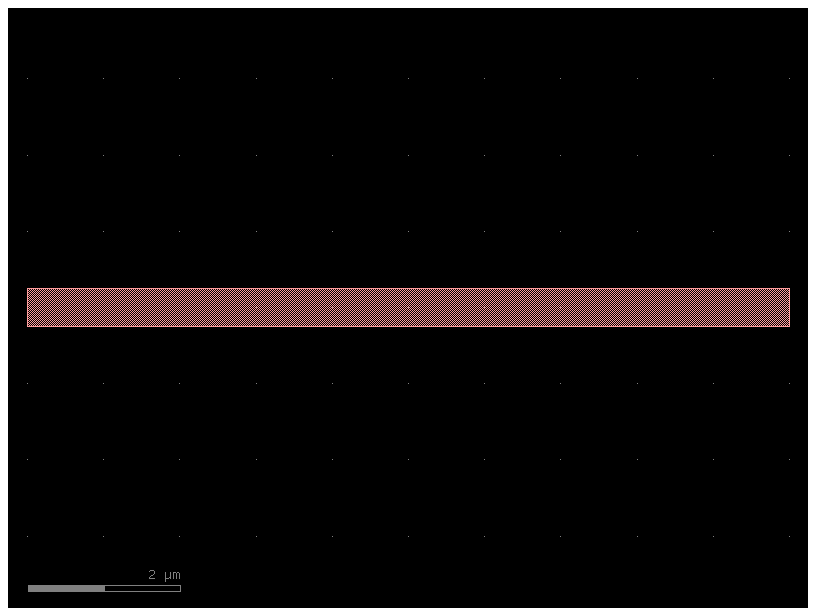

In [24]:
import gdsfactory as gf


# @gf.cell
def die_good():
    c = gf.Component()
    _ = c << gf.components.straight(length=10)
    return gf.components.bbox(c, layer=(1, 0))


c = die_good()
c.plot()